# Summarization using Bidirectional LSTM, pretrained Glove embedding (glove.6B.100d)
## Seq2seq Encoding Decoding

### ROUGE (Recall-Oriented Understudy for Gisting Evaluation), metrics and a software package used for evaluating automatic summarization


In [ ]:
!pip install rouge
!pip install tensorflow

In [3]:
#Sorting out Libraries
import re
import string
import csv
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from rouge import Rouge
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model


### Reading the dataset
#### Amazon Fine Food Reviews

In [7]:
data = pd.read_csv('Reviews.csv')

data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
len(data)

568454

In [9]:
#Alter the size of the dataset
#test_data size will be about 10k pairs

train_data  = data.truncate(after=50000)
test_data = data.truncate(before = 60000, after = 70000)

In [13]:
train_data = train_data.loc[:, ['Text', 'Summary']]
train_data.drop_duplicates('Text', inplace = True)     # drop duplicate reviews
train_data.dropna(axis = 0, inplace = True)            # drop rows that have NA

In [14]:
test_data = train_data.loc[:, ['Text', 'Summary']]
test_data.drop_duplicates('Text', inplace = True)     # drop duplicate reviews
test_data.dropna(axis = 0, inplace = True)           # drop rows that have NA

# Preprocessing the data
## Following preprocessing tasks are performed on data:

Converting to lowercase

Removing HTML tags

Contraction mapping

Removing (‘s)

Removing text inside parenthesis ( )

Removing punctuations and special characters

Removing stopwords

Removing short words

In [ ]:
 #Contraction mapping
#below is the dictionary we'll use to expand the contractions

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [16]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contraction_mapping:
            tmp.append(contraction_mapping[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)
        
    return text

In [17]:
len(train_data)

46254

In [20]:
train_data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [21]:
# Performing the preprocessing

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

clean_summaries = []
for summary in train_data.Summary:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('Cleaning Summaries Complete')
    
clean_texts = []
for text in train_data.Text:
    clean_texts.append(clean_text(text))
print('Cleaning Texts Complete')
del train_data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaning Summaries Complete
Cleaning Texts Complete


In [22]:
# Define a new clean dataframe with 45000 text and summary pairs

clean_df = pd.DataFrame()
clean_df['text'] = clean_texts[:45000]
clean_df['summary'] = clean_summaries[:45000]
clean_df['summary'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

# adding start and end tokens for each summary 
clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')


# checking out the cleaned versions


In [81]:
for i in range(5):
    print('Review:', clean_df['text'][i])
    print('Summary:', clean_df['summary'][i])
    print('\n')

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: <sostok> good quality dog food <eostok>


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: <sostok> not as advertised <eostok>


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: <sostok>  delight  says it all <eostok>


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered good made cherry soda flavor medicinal
Summary: <sostok> cough medicine <eostok>


Review: great taffy great price wide assortment yummy taffy de

# Let's understand the distribution of sequences

In [67]:
length_of_texts = []
length_of_summaries = []

for i in range(len(clean_df.index)):
    length_of_texts.append(len(clean_df.at[i, 'text'].split()))
    length_of_summaries.append(len(clean_df.at[i, 'summary'].split()))

lengths_df = pd.DataFrame({'text': length_of_texts, 
                            'summary': length_of_summaries})

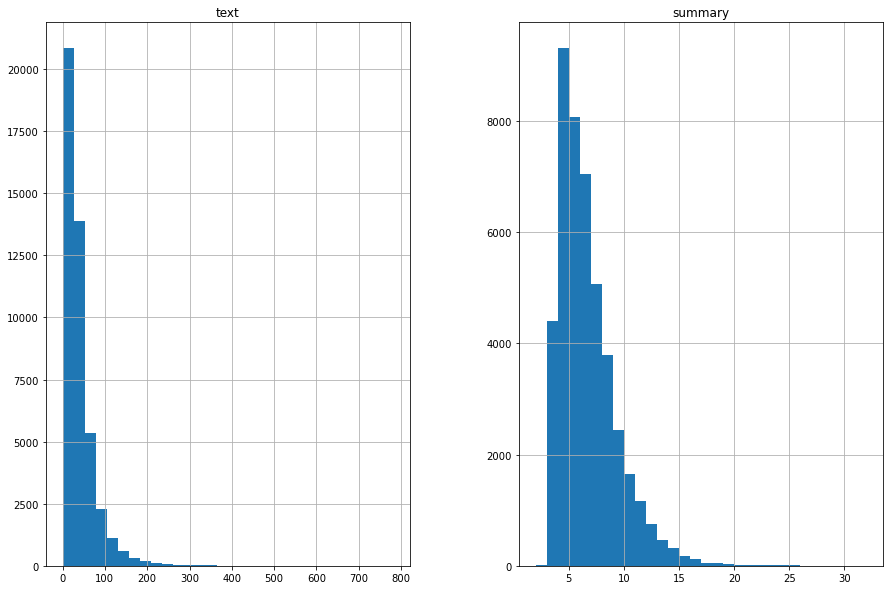

In [68]:
lengths_df.hist(bins = 30, figsize=(15,10))
plt.show()


 we can fix the maximum text length to 80 as since 89% of sequence are below this length

In [69]:
cnt=0
for i in clean_df['text']:
    if(len(i.split())<=80):
        cnt=cnt+1
print(cnt/len(clean_df['text']))

0.8958


we can fix the maximum summary length to 10 as since 92% of sequence are below this length

In [71]:
cnt=0
for i in clean_df['summary']:
    if(len(i.split())<=10):
        cnt=cnt+1
print(cnt/len(clean_df['summary']))

0.9288222222222222


In [23]:
clean_df.head()

,text,summary
0,bought several vitality canned dog food produc...,<sostok> good quality dog food <eostok>
1,product arrived labeled jumbo salted peanuts p...,<sostok> not as advertised <eostok>
2,confection around centuries light pillowy citr...,<sostok> delight says it all <eostok>
3,looking secret ingredient robitussin believe f...,<sostok> cough medicine <eostok>
4,great taffy great price wide assortment yummy ...,<sostok> great taffy <eostok>


This looks good

In [24]:
len(clean_df)

45000

# Tokenizing

In [25]:
train_x, test_x, train_y, test_y = train_test_split(clean_df['text'], clean_df['summary'], test_size=0.1, random_state=0)


In [26]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [27]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)

% of rare words in vocabulary:  61.427122454014636
Total Coverage of rare words:  1.9305421292560698
Text Vocab:  14071


In [28]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [29]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
s_max_features = total_count-count
print('Summary Vocab: ', s_max_features)

% of rare words in vocabulary:  76.83921029368432
Total Coverage of rare words:  5.266456929317449
Summary Vocab:  2358


## Rare word coverage in text
#### removing the rare words
#### rare words occur less frequently throughout the entire data.

In [31]:
maxlen_text = 80
maxlen_summ = 10

val_x = test_x

t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))

train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [32]:
val_y = test_y

s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))

train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

In [33]:
print("Training Sequence", train_x.shape)
print('Target Values Shape', train_y.shape)
print('Test Sequence', val_x.shape)
print('Target Test Shape', val_y.shape)

Training Sequence (40500, 80)
Target Values Shape (40500, 10)
Test Sequence (4500, 80)
Target Test Shape (4500, 10)


# Pretrained Glove Embedding

#### “Global Vectors for Word Representation” is better than Word2Vec for preserving the global contexts. It creates a global co-occurrence matrix by estimating probability a given word will co-occur with the other words. 

In [35]:
#compute index mapping words to known embeddings

embeding_index = {}
embed_dim = 100
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs

#### we can use embedding_index dictionary and word_index to compute the embedding matrices

In [36]:
t_embed = np.zeros((t_max_features, embed_dim))
for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

In [37]:
s_embed = np.zeros((s_max_features, embed_dim))
for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec



# Model Building (training of weights)

In [46]:
latent_dim = 128

# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)

# bidirectional LSTM
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])

#Set up the Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)

# LSTM using encode_states as initial state
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

#Dense Layer
dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

#Define the model
model = Model([enc_input, dec_input], dec_output)
model.summary()



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 80, 100)      1407100     ['input_9[0][0]']                
                                                                                                  
 input_10 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  [(None, 256),       234496      ['embedding_8[0][0]']            
 )                               (None, 128),                                               

In [ ]:
#Sparse categorical cross-entropy as the loss function converts integer 
#sequence to One Hot Vector with ease and alleviates memory issues
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

In [ ]:
#using early stop to stop the training once the validation loss increases
#Here we have used patience 2 which means how long(epochs) to wait after increase in validation loss
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [47]:
#Training model on 128 batch size and validate it on a holdout set
model.fit([train_x, train_y[:, :-1]], 
          train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], 
          epochs=5, 
          callbacks=[early_stop], 
          batch_size=128, 
          verbose=2, 
          validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/5
317/317 - 428s - loss: 2.9050 - val_loss: 2.6254 - 428s/epoch - 1s/step
Epoch 2/5
317/317 - 538s - loss: 2.5979 - val_loss: 2.4965 - 538s/epoch - 2s/step
Epoch 3/5
317/317 - 416s - loss: 2.4848 - val_loss: 2.4010 - 416s/epoch - 1s/step
Epoch 4/5
317/317 - 412s - loss: 2.4010 - val_loss: 2.3324 - 412s/epoch - 1s/step
Epoch 5/5
317/317 - 414s - loss: 2.3358 - val_loss: 2.2729 - 414s/epoch - 1s/step


In [65]:
#Forgot to record the losses, so created an array manually
val_loss = [2.6254,2.4965,2.4010,2.3324,2.2729]
loss = [2.9050,2.5979,2.4848,2.4010,2.3358 ]

# The Diagnostic plot

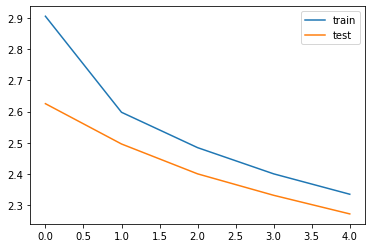

In [64]:
import matplotlib.pyplot as plt

# Evaluation of plot
plt.plot(loss, label = 'train')
plt.plot(val_loss, label = 'test')
plt.legend()
plt.show()

In [82]:
# Encoding input sequence to get feature vector
enc_model = Model(inputs=enc_input, outputs=[enc_h, enc_c])

In [83]:
# Below is Decoder setup:
dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

In [84]:
# These are tensors that to hold the states of the previous time step
dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)


dec_model = Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

### Below function is the implementation of the infrence process

In [49]:
## Actual decoding function
def generate_summary(input_seq):
    h, c = enc_model.predict(input_seq)
    
    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''
    
    stop = False
    count = 0
    
    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])
        
        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token
        
        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1
        
    return output_seq

In [54]:
test_inputs = [clean_text(sent) for sent in test_data.Text]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

In [57]:
test_data1 = test_data.copy(deep = True)

In [58]:
test_data.reset_index(inplace = True,drop = True)

# Some summaries our model generated

In [78]:
for i in range(10):
    
    our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
    print('Review: ', test_data.Text[i])
    print('Original summary: ',test_data.Summary[i])
    print('Predicted summary: ',our_summ)
    print("\n")



1/1 [==============================] - 0s 23ms/step
Review:  I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Original summary:  Good Quality Dog Food
Predicted summary:   great product


1/1 [==============================] - 0s 25ms/step
Review:  Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
Original summary:  Not as Advertised
Predicted summary:   great product


1/1 [==============================] - 0s 23ms/step
Review:  This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar

### Generated the CSV containing 500 original articles, given summaries and model produced summmaries 

In [59]:
hyps = []
with open('./result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(500):
        our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
        hyps.append(our_summ)
        writer.writerow([test_data.Text[i], test_data.Summary[i], our_summ])

1/1 [==============================] - 0s 24ms/step


# Rouge Score

In [61]:
rouge = Rouge()
rouge.get_scores(hyps, test_data.Summary, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.018372459204122532,
  'p': 0.027054108216432865,
  'f': 0.01995543955197139},
 'rouge-2': {'r': 0.000250501002004008,
  'p': 0.000668002672010688,
  'f': 0.00036436508587422793},
 'rouge-l': {'r': 0.018172058402519325,
  'p': 0.026052104208416832,
  'f': 0.01962143821596605}}